In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score


# Metrics (distance) and stats
from scipy.spatial.distance import euclidean
from scipy.stats import median_abs_deviation

# Unsupervised (Machine) Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#ANN
import torch
import torch.nn as nn
import torch.optim as optim

# save data
import pickle

In [2]:
# Tải dữ liệu training từ file
with open('./ieee-fraud-detection-lite/train-scaled.pickle', 'rb') as f:
    X_train_scaled = pickle.load(f)

with open('./ieee-fraud-detection-lite/label-train-scaled.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('./ieee-fraud-detection-lite/val-scaled.pickle', 'rb') as f:
    X_val_scaled = pickle.load(f)

with open('./ieee-fraud-detection-lite/label-val-scaled.pickle', 'rb') as f:
    y_val = pickle.load(f)

### Phân bố dữ liệu

In [4]:
visualisation_initial = X_train_scaled
features, labels = visualisation_initial, y_train

In [6]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

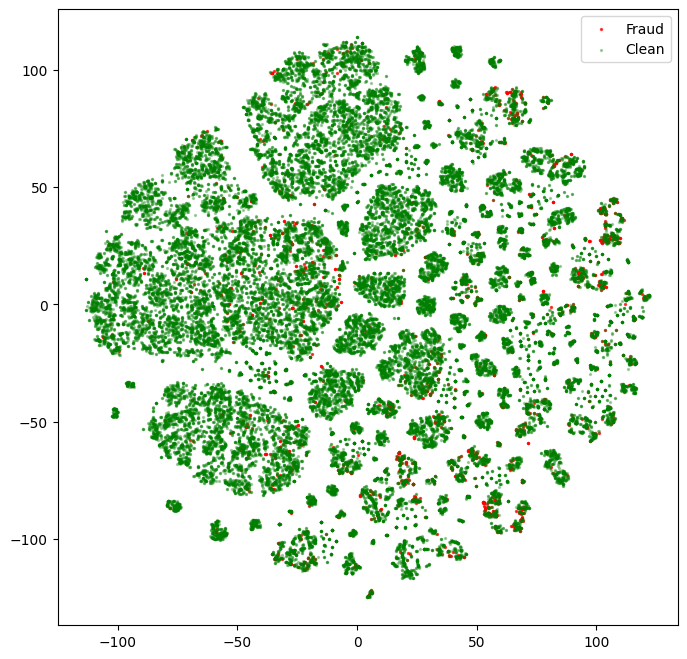

In [7]:
tsne_scatter(features, labels, dimensions=2)

### ANN

In [234]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.Sigmoid(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.Sigmoid()
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim//4, hidden_dim//2),
            nn.Sigmoid(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [235]:
input_dim = 245
hidden_dim = 128

In [236]:
# Create an instance of the auto-encoder model
model = AutoEncoder(input_dim, hidden_dim)

In [237]:
# load model
model.load_state_dict(torch.load('./model/weights_sgd_1.pth'))

<All keys matched successfully>

In [238]:
X_train_anc = X_train_scaled[y_train == 0]
X_train_atn = torch.tensor(X_train_anc, dtype=torch.float32)
with torch.no_grad():
    decoded = model(X_train_atn)
mse_train = torch.mean((decoded - X_train_atn) ** 2, axis=1)
mse_train.numpy().mean()

0.011248345

In [239]:
X_test_anc = X_val_scaled[y_val == 0]
X_test_atn = torch.tensor(X_test_anc, dtype=torch.float32)
with torch.no_grad():
    decoded = model(X_test_atn)
mse_test = torch.mean((decoded - X_test_atn) ** 2, axis=1)
mse_test.numpy().mean()

0.07093449

### Xác định ngưỡng bằng phương pháp Robust Z-score method

- MAD = median{xi-x_median}
- Mi = 0.6745*(xi-x_median)/MAD
- 0.6745 là phân vị thứ 0.75 của phân phối mà đã được thử nghiệm đến đó MAD đạt khả năng phát hiện tốt nhất.
- Theo nguyên tắc chung, chúng tôi sẽ sử dụng điểm 3 làm giá trị giới hạn của mình; Điều này có nghĩa là mọi điểm có điểm trên 3 sẽ được coi là ngoại lệ. sau đó tinh chỉnh ngưỡng cho phù hợp với bài toán cụ thể.

* Phương pháp được chứng minh hiệu quả trong bài báo: Boris Iglewicz and David Hoaglin, "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.

In [240]:
X_train_anc = X_train_scaled
X_train_atn = torch.tensor(X_train_anc, dtype=torch.float32)
with torch.no_grad():
    decoded = model(X_train_atn)
mse_train = torch.mean((decoded - X_train_atn) ** 2, axis=1)

In [241]:
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

In [242]:
THRESHOLD = 1
z_scores = mad_score(mse_train)
outliers = z_scores < THRESHOLD

In [243]:
# precision: khả năng chính xác khi dự báo là 1 class nao đó của mô hình
# recall: đại diện cho độ chính xác phát hiện 1 class nào đó
cm = confusion_matrix(y_train, outliers)
print(cm)
# Tạo báo cáo đánh giá
report = classification_report(y_train, outliers)

print(report)

[[14976 33235]
 [  830   959]]
              precision    recall  f1-score   support

           0       0.95      0.31      0.47     48211
           1       0.03      0.54      0.05      1789

    accuracy                           0.32     50000
   macro avg       0.49      0.42      0.26     50000
weighted avg       0.91      0.32      0.45     50000



In [244]:
# Assuming you have loaded your testing set as X_test
X_test_atn = torch.tensor(X_val_scaled, dtype=torch.float32)

# Use the model to encode and decode the input data
# with torch.no_grad():
#     encoded = model.encoder(X_test_atn)
#     decoded = model.decoder(encoded)
with torch.no_grad():
    decoded = model(X_test_atn)

In [245]:
# Get the reconstruction loss for each input in the testing set
mse = torch.mean((decoded - X_test_atn) ** 2, axis=1)

In [246]:
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

In [247]:
THRESHOLD = 1
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [248]:
cm = confusion_matrix(y_val, outliers)
print(cm)
# Tạo báo cáo đánh giá
report = classification_report(y_val, outliers)

print(report)

[[16993  7132]
 [  494   381]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     24125
           1       0.05      0.44      0.09       875

    accuracy                           0.69     25000
   macro avg       0.51      0.57      0.45     25000
weighted avg       0.94      0.69      0.79     25000



### Traditional machine learning based method: SVM
- SVM là một thuật toán mạnh mẽ trong phân loại, tuy nhiên với dữ liệu mất cân bằng như này thì có thể gây khó khăn cho thuật toán.

In [198]:
from sklearn import svm

In [199]:
clf = svm.SVC()

In [200]:
clf.fit(X_train_scaled, y_train)

SVC()

In [201]:
# Dự đoán nhãn của dữ liệu kiểm tra
y_pred = clf.predict(X_val_scaled)

In [202]:
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)
# Tạo báo cáo đánh giá
report = classification_report(y_val, y_pred)

print(report)

[[24122     3]
 [  870     5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     24125
           1       0.62      0.01      0.01       875

    accuracy                           0.97     25000
   macro avg       0.80      0.50      0.50     25000
weighted avg       0.95      0.97      0.95     25000



### Voting based method: Random Forest
- Random Forest sử dụng phương pháp lấy mẫu bootstrap để huấn luyện các cây quyết định có thể giúp giảm hiện tượng dữ liệu mất cân bằng.

In [203]:
rfc = RandomForestClassifier()

In [204]:
rfc.fit(X_train_scaled, y_train)
y_predproba = rfc.predict_proba(X_val_scaled)

In [205]:
y_pred = [1 if prob[1] > 0.5 else 0 for prob in y_predproba]

In [206]:
conf_matrix = confusion_matrix(y_val, y_pred)

In [207]:
conf_matrix

array([[24068,    57],
       [  661,   214]], dtype=int64)

In [208]:
# Tạo báo cáo đánh giá
report = classification_report(y_val, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     24125
           1       0.79      0.24      0.37       875

    accuracy                           0.97     25000
   macro avg       0.88      0.62      0.68     25000
weighted avg       0.97      0.97      0.96     25000



### Kmeans

In [209]:
# Find the ideal number of clusters 
def find_optimal_k_clusters_plot(dataframe, minK, maxK, titlePlot, random_state = 42):
    """
    This function displays a plot of the Silhouette Score.
    The objective of this function is to visually identify the optimal number of clusters
    
    * **`dataframe`** (_pandas.DataFrame_): The dataframe previously processed
    * **`features_names`** (_array like_): A list or ndarray with the name of the columns/features to be used.
    * **`minK`** and **`maxK`** (_int_): are the minimun (inclusive) and maximum (non inclusive)
    amount of clusters to test.
    * **`random_state`** (_default = 11_): Is a random seed for reproducibility 
    """
    X = dataframe
    list_models = []

    for i in range(minK, maxK):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        list_models.append(kmeans)
    
    sil_scores = [silhouette_score(X, model.labels_, random_state=random_state) 
                  for model in list_models[1:]]
    
    # P L O T   R E S U L T S
    plt.plot(range(minK + 1, maxK), sil_scores,
             linestyle = ':', marker = 'o', color = 'maroon', label = 'Silhouette score')
    plt.ylabel('Silhouette Score')
    plt.xlabel('no. cluster')

In [231]:
# Xác định số cụm bằng phương pháp: Silhouette score
"""
Công thức tính Silhouette score cho một điểm dữ liệu trong phân cụm là:

Silhouette score = (b - a) / max(a, b)

Trong đó:

a: Trung bình khoảng cách từ điểm dữ liệu đó đến các điểm dữ liệu trong cùng một cụm.
b: Trung bình khoảng cách từ điểm dữ liệu đó đến các điểm dữ liệu trong cụm gần nhất (không phải cụm chứa điểm đó).

"""

'\nCông thức tính Silhouette score cho một điểm dữ liệu trong phân cụm là:\n\nSilhouette score = (b - a) / max(a, b)\n\nTrong đó:\n\na: Trung bình khoảng cách từ điểm dữ liệu đó đến các điểm dữ liệu trong cùng một cụm.\nb: Trung bình khoảng cách từ điểm dữ liệu đó đến các điểm dữ liệu trong cụm gần nhất (không phải cụm chứa điểm đó).\n\n'

C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ADM

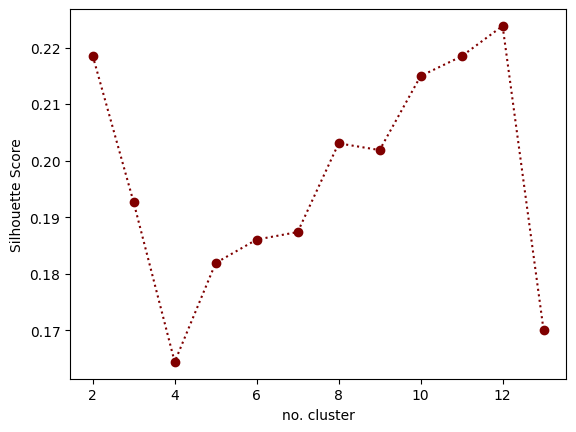

In [232]:
find_optimal_k_clusters_plot(dataframe = X_train_scaled, minK = 1, maxK= 14, titlePlot="Silhouette score")

In [211]:
kmeans_01 = KMeans(n_clusters=12, random_state=11)
kmeans_01.fit(X_train_scaled)

C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=12, random_state=11)

In [212]:
labels = kmeans_01.predict(X_train_scaled)
class_labels = y_train
# Tạo một danh sách các cluster duy nhất
unique_clusters = np.unique(labels)

# Tính số lượng phần tử và số lượng phần tử class 1 trong từng cluster
for cluster_id in unique_clusters:
    cluster_indices = np.where(labels == cluster_id)
    cluster_size = len(cluster_indices[0])
    class_1_count = np.count_nonzero(class_labels[cluster_indices])
    print(f"Cluster {cluster_id}: {cluster_size} phần tử, {class_1_count} phần tử class 1")

Cluster 0: 3172 phần tử, 156 phần tử class 1
Cluster 1: 4376 phần tử, 57 phần tử class 1
Cluster 2: 4748 phần tử, 82 phần tử class 1
Cluster 3: 6334 phần tử, 105 phần tử class 1
Cluster 4: 2436 phần tử, 91 phần tử class 1
Cluster 5: 2925 phần tử, 198 phần tử class 1
Cluster 6: 3032 phần tử, 300 phần tử class 1
Cluster 7: 3916 phần tử, 49 phần tử class 1
Cluster 8: 3772 phần tử, 53 phần tử class 1
Cluster 9: 3438 phần tử, 142 phần tử class 1
Cluster 10: 9550 phần tử, 284 phần tử class 1
Cluster 11: 2301 phần tử, 272 phần tử class 1


In [213]:
### Nhận xét
"""
- Các giao dịch gian lận tồn tại trong các cluster.
- Các giao dịch gian lận rất tinh vi.
"""

'\n- Các giao dịch gian lận tồn tại trong các cluster.\n- Các giao dịch gian lận rất tinh vi.\n'

In [214]:
df_01 = pd.DataFrame()

In [215]:
# Get labels and clusters
arr_labels_01 = kmeans_01.predict(X_train_scaled).reshape((-1,1))
arr_centroids_01 = kmeans_01.cluster_centers_

# Label the data with the predictions in the data frame
df_01['clusters'] = arr_labels_01.flatten()

# Create array of features and labels
arr_features_labels_01 = np.column_stack((X_train_scaled, np.array(df_01['clusters'])))

In [216]:
# Get distance to centroid
def get_distance_centroid(array, centroids):
    vector = array[:-1]
    label = array[-1]
    centroid = centroids[int(label)]
    dist = euclidean(vector, centroid)
    return dist

In [217]:
# Find distance
arr_distances_centroid_01 = np.apply_along_axis(func1d = get_distance_centroid, axis=1,
                                                arr= arr_features_labels_01,
                                                centroids = arr_centroids_01)
# Add data to data frame
df_01['distance_centroid'] = arr_distances_centroid_01

In [218]:
df_01

,clusters,distance_centroid
0,6,1.315575
1,10,0.665181
2,10,0.648596
3,1,1.350526
4,7,1.302631
...,...,...
49995,7,0.942367
49996,2,1.263027
49997,2,0.705518
49998,4,1.220394


In [219]:
# Get distance to centroid (Standardised)
def calculate_modifed_z_score(array, medians, mads):
    distance, label = array
    median = medians[int(label)]
    mad = mads[int(label)]
    z_mod = 0.6745 *(distance - median)/mad
    return z_mod

In [220]:
arr_distances_labels_01 = df_01[['distance_centroid','clusters']].values

In [221]:
median_01_0 = np.median(df_01.query("clusters == 0")['distance_centroid'].values)
median_01_1 = np.median(df_01.query("clusters == 1")['distance_centroid'].values)
median_01_2 = np.median(df_01.query("clusters == 2")['distance_centroid'].values)
median_01_3 = np.median(df_01.query("clusters == 3")['distance_centroid'].values)
median_01_4 = np.median(df_01.query("clusters == 4")['distance_centroid'].values)
median_01_5 = np.median(df_01.query("clusters == 5")['distance_centroid'].values)
median_01_6 = np.median(df_01.query("clusters == 6")['distance_centroid'].values)
median_01_7 = np.median(df_01.query("clusters == 7")['distance_centroid'].values)
median_01_8 = np.median(df_01.query("clusters == 8")['distance_centroid'].values)
median_01_9 = np.median(df_01.query("clusters == 9")['distance_centroid'].values)
median_01_10 = np.median(df_01.query("clusters == 10")['distance_centroid'].values)
median_01_11 = np.median(df_01.query("clusters == 11")['distance_centroid'].values)
list_medians_01 = [median_01_0, median_01_1, median_01_2, median_01_3, median_01_4, median_01_5, median_01_6, median_01_7, median_01_8, median_01_9, median_01_10, median_01_11]

mads_01_0 = median_abs_deviation(df_01.query("clusters == 0")['distance_centroid'].values)
mads_01_1 = median_abs_deviation(df_01.query("clusters == 1")['distance_centroid'].values)
mads_01_2 = median_abs_deviation(df_01.query("clusters == 2")['distance_centroid'].values)
mads_01_3 = median_abs_deviation(df_01.query("clusters == 3")['distance_centroid'].values)
mads_01_4 = median_abs_deviation(df_01.query("clusters == 4")['distance_centroid'].values)
mads_01_5 = median_abs_deviation(df_01.query("clusters == 5")['distance_centroid'].values)
mads_01_6 = median_abs_deviation(df_01.query("clusters == 6")['distance_centroid'].values)
mads_01_7 = median_abs_deviation(df_01.query("clusters == 7")['distance_centroid'].values)
mads_01_8 = median_abs_deviation(df_01.query("clusters == 8")['distance_centroid'].values)
mads_01_9 = median_abs_deviation(df_01.query("clusters == 6")['distance_centroid'].values)
mads_01_10 = median_abs_deviation(df_01.query("clusters == 7")['distance_centroid'].values)
mads_01_11 = median_abs_deviation(df_01.query("clusters == 8")['distance_centroid'].values)
list_mads_01 = [mads_01_0, mads_01_1, mads_01_2, mads_01_3, mads_01_4, mads_01_5, mads_01_6, mads_01_7, mads_01_8, mads_01_9, mads_01_10, mads_01_11]

In [222]:
arr_z_mod_01 = np.apply_along_axis(func1d= calculate_modifed_z_score,
                                   arr= arr_distances_labels_01,
                                   axis = 1,
                                   medians = list_medians_01,
                                   mads = list_mads_01
                                  )

In [223]:
df_01['z_mod'] = arr_z_mod_01
df_01.head()

,clusters,distance_centroid,z_mod
0,6,1.315575,-0.477005
1,10,0.665181,-0.311303
2,10,0.648596,-0.364429
3,1,1.350526,0.866674
4,7,1.302631,0.119970


In [224]:
error = np.array(df_01['z_mod'])

In [225]:
THRESHOLD = 0.5
outliers = np.array(df_01['z_mod']) > THRESHOLD

In [226]:
cm = confusion_matrix(y_train, outliers)
print(cm)
# Tạo báo cáo đánh giá
report = classification_report(y_train, outliers)

print(report)

[[34214 13997]
 [ 1152   637]]
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     48211
           1       0.04      0.36      0.08      1789

    accuracy                           0.70     50000
   macro avg       0.51      0.53      0.45     50000
weighted avg       0.93      0.70      0.79     50000



In [227]:
df_01 = pd.DataFrame()
# Get labels and clusters
arr_labels_01 = kmeans_01.predict(X_val_scaled).reshape((-1,1))
arr_centroids_01 = kmeans_01.cluster_centers_

# Label the data with the predictions in the data frame
df_01['clusters'] = arr_labels_01.flatten()

# Create array of features and labels
arr_features_labels_01 = np.column_stack((X_val_scaled, np.array(df_01['clusters'])))
# Find distance
arr_distances_centroid_01 = np.apply_along_axis(func1d = get_distance_centroid, axis=1,
                                                arr= arr_features_labels_01,
                                                centroids = arr_centroids_01)
# Add data to data frame
df_01['distance_centroid'] = arr_distances_centroid_01

# Find distance
arr_distances_centroid_01 = np.apply_along_axis(func1d = get_distance_centroid, axis=1,
                                                arr= arr_features_labels_01,
                                                centroids = arr_centroids_01)
# Add data to data frame
df_01['distance_centroid'] = arr_distances_centroid_01

arr_distances_labels_01 = df_01[['distance_centroid','clusters']].values

median_01_0 = np.median(df_01.query("clusters == 0")['distance_centroid'].values)
median_01_1 = np.median(df_01.query("clusters == 1")['distance_centroid'].values)
median_01_2 = np.median(df_01.query("clusters == 2")['distance_centroid'].values)
median_01_3 = np.median(df_01.query("clusters == 3")['distance_centroid'].values)
median_01_4 = np.median(df_01.query("clusters == 4")['distance_centroid'].values)
median_01_5 = np.median(df_01.query("clusters == 5")['distance_centroid'].values)
median_01_6 = np.median(df_01.query("clusters == 6")['distance_centroid'].values)
median_01_7 = np.median(df_01.query("clusters == 7")['distance_centroid'].values)
median_01_8 = np.median(df_01.query("clusters == 8")['distance_centroid'].values)
median_01_9 = np.median(df_01.query("clusters == 9")['distance_centroid'].values)
median_01_10 = np.median(df_01.query("clusters == 10")['distance_centroid'].values)
median_01_11 = np.median(df_01.query("clusters == 11")['distance_centroid'].values)
list_medians_01 = [median_01_0, median_01_1, median_01_2, median_01_3, median_01_4, median_01_5, median_01_6, median_01_7, median_01_8, median_01_9, median_01_10, median_01_11]

mads_01_0 = median_abs_deviation(df_01.query("clusters == 0")['distance_centroid'].values)
mads_01_1 = median_abs_deviation(df_01.query("clusters == 1")['distance_centroid'].values)
mads_01_2 = median_abs_deviation(df_01.query("clusters == 2")['distance_centroid'].values)
mads_01_3 = median_abs_deviation(df_01.query("clusters == 3")['distance_centroid'].values)
mads_01_4 = median_abs_deviation(df_01.query("clusters == 4")['distance_centroid'].values)
mads_01_5 = median_abs_deviation(df_01.query("clusters == 5")['distance_centroid'].values)
mads_01_6 = median_abs_deviation(df_01.query("clusters == 6")['distance_centroid'].values)
mads_01_7 = median_abs_deviation(df_01.query("clusters == 7")['distance_centroid'].values)
mads_01_8 = median_abs_deviation(df_01.query("clusters == 8")['distance_centroid'].values)
mads_01_9 = median_abs_deviation(df_01.query("clusters == 6")['distance_centroid'].values)
mads_01_10 = median_abs_deviation(df_01.query("clusters == 7")['distance_centroid'].values)
mads_01_11 = median_abs_deviation(df_01.query("clusters == 8")['distance_centroid'].values)
list_mads_01 = [mads_01_0, mads_01_1, mads_01_2, mads_01_3, mads_01_4, mads_01_5, mads_01_6, mads_01_7, mads_01_8, mads_01_9, mads_01_10, mads_01_11]

arr_z_mod_01 = np.apply_along_axis(func1d= calculate_modifed_z_score,
                                   arr= arr_distances_labels_01,
                                   axis = 1,
                                   medians = list_medians_01,
                                   mads = list_mads_01
                                  )

In [228]:
arr_z_mod_01 = np.apply_along_axis(func1d= calculate_modifed_z_score,
                                   arr= arr_distances_labels_01,
                                   axis = 1,
                                   medians = list_medians_01,
                                   mads = list_mads_01
                                  )

In [229]:
df_01['z_mod'] = arr_z_mod_01
df_01.head()

,clusters,distance_centroid,z_mod
0,3,1.226181,1.087487
1,7,1.043109,-1.386053
2,9,1.373056,0.046400
3,2,0.987044,-0.195405
4,5,1.762483,1.979842


In [230]:
error = np.array(df_01['z_mod'])
THRESHOLD = 0.5
outliers = np.array(df_01['z_mod']) > THRESHOLD
cm = confusion_matrix(y_val, outliers)
print(cm)
# Tạo báo cáo đánh giá
report = classification_report(y_val, outliers)

print(report)

[[17031  7094]
 [  606   269]]
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     24125
           1       0.04      0.31      0.07       875

    accuracy                           0.69     25000
   macro avg       0.50      0.51      0.44     25000
weighted avg       0.93      0.69      0.79     25000



### Kết luận

#### Thống kê kết quả
| Model          | Precision (Class 0) | Recall (Class 0) | Precision (Class 1) | Recall (Class 1) |
| -------------- | ------------------ | ---------------- | ------------------- | ---------------- |
| ANN            | 0.97               | 0.7              | 0.05                | 0.44             |
| SVM            | 0.97               | 1                | 0.62                | 0.01             |
| Random Forest  | 0.97               | 1                | 0.79                | 0.24             |
| Kmeans         | 0.97               | 0.71             | 0.04                | 0.31             |


#### Nhận xét
- Có sự đánh đổi precision và recall các lớp.
- Mô hình Random Forest đạt được kết quả chấp nhận được khi nhận biết 2 lớp.
- Các hành vi gian lận rất tinh vi, chúng không hình thành 1 quy luật rõ ràng, đó là thử thách với đề tài.

### Công việc tương lai

- Thử nghiệm các phương pháp khác để xử lý dữ liệu mất cân bằng: undersampling, oversampling data.
